## The network SEI8R model

The dynamical equations are given as

\begin{align}
\dot{S_{in}}	    &=-\lambda_{in}(t)S_{in}+\sigma_{in},\\
\dot{E}_{in}	    &=\lambda_{i}(t)S_{in}-\gamma_{E}E_{in},\\
\dot{I}_{in}^{a}	&=\alpha\gamma_{E}E_{in}-\gamma_{I^{a}}I_{in}^{a},\\
\dot{I}_{in}^{s}	&=\bar{\alpha}\gamma_{E}E_{in}-\gamma_{I^{s}}I_{in}^{s},\\
\dot{I}_{in}^{s'}	&=\bar{h_{i}}\gamma_{I^{s}}I_{in}^{s}-\gamma_{I^{s'}}I_{in}^{s'},\\
\dot{I}_{in}^{h}	&=h_{i}\gamma_{I^{s}}I_{in}^{s}-\gamma_{I^{h}}I_{in}^{h},\\
\dot{I}_{in}^{h'}	&=\bar{c_{i}}\gamma_{I^{h}}I_{in}^{h}-\gamma_{I^{s'}}I_{in}^{h'},\\
\dot{I}_{in}^{c}	&=c_{i}\gamma_{I^{h}}I_{in}^{h}-\gamma_{I^{c}}I_{in}^{c},\\
\dot{I}_{in}^{c'}	&=\bar{m_{i}}\gamma_{I^{c}}I_{in}^{c}-\gamma_{I^{c'}}I_{in}^{c'},\\
\dot{I}_{in}^{m}	&=m_{i}\gamma_{I^{c}}I_{in}^{c},\\
\dot{N}^{H}_{in}	    &=\sigma_{in}-m_{in}\gamma_{I^{c}}I_{in}^{c}
\end{align}

The key idea is to note that the rate of infection of a susceptible individual in age group `i` at the node `n` is given as

\begin{align}
\lambda_{in}(t)=\lambda^0_{in}(t)=\beta\sum_{j=1}^{M}\left(C_{ij}\frac{I_{jn}^{a}}{N^{H}_{jn}}+f_{sa}C_{ij}\frac{I_{jn}^{s}}{N^{H}_{jn}} + f_{h} C_{ij}\frac{I_{jn}^{h}}{N^{H}_{jn}}\right),
\end{align}


Commute can then be modeled by changing this to


\begin{align}
\lambda_{in}^{T}(t)=\beta r^{T}\sum_{j=1}^{M}\sum_{m=1}^{N_{d}} \sum_{<k,l>} C_{ij} \frac{D_{j,kl}}{N^{H}_{j,l}} \frac{I_{jl}^{a} + f_{sa} I_{jl}^{s} + f_{h} I_{jl}^{h}}{N^{T}_{j,mn}} \frac{D_{i,mn}}{N^{H}_{i,n}},
\end{align}


while workplace interaction can be modeled as


\begin{align}
\lambda_{in}^{W}(t)=\beta r^{W}\sum_{j=1}^{M}\sum_{m,k=1}^{N_{d}} C_{ij} \frac{D_{j,mk}}{N^{H}_{jk}} \frac{I_{jk}^{a} + f_{sa} I_{jk}^{s} + f_{h} I_{jk}^{h}}{N^{W}_{jm}}  \frac{D_{i,mn}}{N^{H}_{in}}.
\end{align}

The derivation of all equations is wrriten in [the documentation](https://github.com/lukastk/PyRossGeo/tree/master/docs/mft-model.pdf).
The simulation then runs by choosing appropriate $\lambda$ as a function of time. The constants $r_T$ and $r_W$ control the strength of interactions. In this model, we assume that each route between the nodes connects the neighbour nodes only.

The defiintion of the variables are in following.
$D_{i,nm}$ is the number of people working at node `n` and livingin `m` in the age group `i`, $N^{H}_{in}=\sum_{m} D_{i,mn}$ is the total number of residence in node `n` and $N^{W}_{in}=\sum_{m} D_{i,nm}$ is the total number of people working at node `n`.
$N_{i,nm}^{T}$ is the effective number of the commuter in the age group `i` using the route between `n` and `m`:

\begin{align}
N^{T}_{i,nm}=\sum_{<kl>}R_{i,kl}\frac{d_{kl}}{d_{nm}},
\end{align}

where $<kl>$ indicate summation of all pair of neighbour node $k$ and $l$ included in the shortest path between node 
`n` and `m` and $d_{nm}$ is the distance between node `n` and `m` along the shortest path. $R_{i,nm}=\sum_{<kl>}D_{i,kl}$ is the number of the commuter in the age group `i` using the route between the neighbor node `n` and `m`. The node `n` and `m` are included in the shortest path between node pair 
$(k,l)$ took up all combinations satisfying the conditions.
Hence, we only need $D_{i,nm}$ and $d_{nm}$ in order to construct this network model. $D_{i,nm}$ can be obtained census datasets and $d_{nm}$ can be determined by the geographical locations. For the calculation of London including 983 nodes, $D_{i,nm}$ and $d_{nm}$ are stored in census.txt and distnaces.txt, respectively.

In [ ]:
%%capture
## compile for this notebook
import os
owd = os.getcwd()
os.chdir('../')
%run setup.py install
os.chdir(owd)

Loading $D_{i,nm}$ and $d_{nm}$ from census.txt and distances.txt

In [2]:
import numpy as np
import pyrossgeo
import matplotlib.pyplot as plt
import math
import os

M = 7 #Aged Group

cutoff = 0
Restricted = [] #the restirected area
if os.path.exists('census.txt') and os.path.exists('distances.txt'):
    f_census = open('census.txt')
    f_distances = open('distances.txt')
    c_lines = f_census.readlines()
    d_lines = f_distances.readlines()
    if len(c_lines) != len(d_lines)*M:
        print('Error. Wrong file Status\n')
        exit()
    
    Nnode=int(len(c_lines)/M)
    census_matrix = np.zeros((M + 1,Nnode, Nnode))
    distances=np.zeros((Nnode, Nnode))
    
    count = 0
    aged_id = 0
    for line in c_lines:
        parameters = line.split()
        for i in range(len(parameters)):
            census_matrix[aged_id,count,i] = float(parameters[i])
        count += 1
        if count == Nnode:
            count = 0
            aged_id += 1

    #Restricted Area
    for alp in range(M):
        for i in Restricted:
            for j in range(Nnode):
                cij = census_matrix[alp,i,j]
                census_matrix[alp,i,j] = 0.0
                census_matrix[alp,j,j] += cij
            
                cij = census_matrix[alp,j,i]
                census_matrix[alp,j,i] = 0.0
                census_matrix[alp,i,i] += cij
    
    #Cutoff
    nonzero_element = 0
    cutoff_total = 0
    c_matrix = census_matrix.copy()
    for alp in range(M):
        for i in range(Nnode):
            for j in range(Nnode):
                cij = c_matrix[alp,i,j]
                if cij > cutoff:
                    nonzero_element += 1
                    cutoff_total += c_matrix[alp,i,j]
                else:
                    census_matrix[alp,i,j] = 0.0
                    #max_wid = np.argsort(census_matrix[:,j])[Nnode- 1]
                    census_matrix[alp,j,j] += cij
    print("The number of nonzero element " + str(nonzero_element) + '/' + str(M*Nnode**2) + ' ' + str(cutoff_total))
    
    #Make Total
    for i in range(Nnode):
        for j in range(Nnode):
            for alp in range(M):
                census_matrix[M,i,j] += census_matrix[alp,i,j]
                
    Nh = np.zeros((M + 1,Nnode)) # The population of ususal residence
    Nw = np.zeros((M + 1,Nnode)) # The number of people working in specific node.
    for alp in range(M):
        for i in range(Nnode):
            Nh[alp,i] = 0.
            Nw[alp,i] = 0.
            for j in range(Nnode):
                Nh[alp,i] += census_matrix[alp,j,i]
                Nw[alp,i] += census_matrix[alp,i,j]
    for alp in range(M):
        for i in range(Nnode):
            Nh[M,i] += Nh[alp,i] ## N^{H}_{i} residence in Node i
            Nw[M,i] += Nw[alp,i] ## N^{W}_{i} working in Node i
    
    count = 0
    for line in d_lines:
        parameters = line.split()
        for i in range(len(parameters)):
            distances[count,i] = float(parameters[i])
        count += 1

# set the matarix D_{nm}
Dnm = census_matrix.copy()

# set the matarix d_{nm}
dnm = distances.copy()

max_wid = np.argsort(Nw[M])[Nnode- 1]
print("Maxmimum City at Working", max_wid, Nw[M,max_wid])
max_rid = np.argsort(Nh[M])[Nnode- 1]
print("Maxmimum City of Residence", max_rid, Nh[M,max_rid])

The number of nonzero element 749693/6764023 4760944.0
Maxmimum City at Working 0 245633.0
Maxmimum City of Residence 859 9752.0


To start network model calculation, we must set $C_{ij}$, model parameters and the initial state. $C_{ij}$ and model parameters can be inferred if we obtain the reasonable initial state. In this tutorial, we set the preliminary values. 

In [3]:
# set the contact structure
C = np.identity(M)
for i in range(M - 1):
    C[i + 1, i] = 1.0
    C[i, i + 1] = 1.0
C *= 1.0
#print(C)
CH = C
CT = C
CW = C
        
# parameters
alpha = 0.5             # fraction of asymptomatic infectives
beta  = 0.2/24          # infection rate
gE    = 0.6/24          # recovery rate of exposed
gIa   = 0.1/24          # recovery rate of asymptomatic infectives 
gIs   = 0.1/24          # recovery rate of symptomatic infectives
gIsd  = 0.2/24          # recovery rate of symptomatic infectives dash
gIh   = 0.1/24          # recovery rate of hospitalized infectives
gIhd  = 0.2/24          # recovery rate of hospitalized infectives dash
gIc   = 0.1/24          # recovery rate of ICU infectives
gIcd  = 0.2/24          # recovery rate of ICU infectives dash
fsa   = 1.0             # the self-isolation parameter
fh    = 0.0             # the hospitalized-isolation parameter
rW    = 1.0             # the interaction controle in WORK (Maybe 1 is a correct value)
rT    = 1.0             # the interaction controle in TRANS (Maybe 1 is a correct value)
hh    = 0.4             # fraction of hospitalized infectives
cc    = 0.4             # fraction of ICU infectives
mm    = 0.4             # fraction of Im infectives

# option
cutoff    = 4.0        # We ignore the number of people moving to other node less than this number.
trv_restriction = 0.0   # travel restriction: 1.0 means everyone stay home

max_wid = np.argsort(Nw[M])[Nnode- 1]
#print("Maxmimum City at Working", max_wid)
max_rid = np.argsort(Nh[M])[Nnode- 1]
#print("Maxmimum City of Residence", max_rid)
min_wid = np.argsort(Nw[M])[0]
#print("Minimum City at Working", min_wid)
min_rid = np.argsort(Nh[M])[0]
#print("Minimum City of Residence", min_rid)

# Initial state
M1 = Nnode*M
E_0   = np.zeros((M1))
Ia_0  = np.zeros((M1))
Is_0  = np.zeros((M1))
Ih_0  = np.zeros((M1))
Ic_0  = np.zeros((M1))
Isd_0 = np.zeros((M1))
Ihd_0 = np.zeros((M1))
Icd_0 = np.zeros((M1))
Im_0  = np.zeros((M1))

Is_0[1*Nnode + max_rid] += 10

R_0 = np.zeros((M1))
N_0 = np.zeros((M1))
for alp in range(M):
    for i in range(Nnode):
        N_0[Nnode*alp + i] = Nh[alp,i]
        
S_0  = N_0 - (Ia_0 + Is_0 + Ih_0 + Ic_0 + Isd_0 + Ihd_0 + Icd_0 + Im_0 + R_0)

# the contact matrix 
def contactMatrix(t):
    t_p_24 = t%24
    if t_p_24 < 8.0 or t_p_24 > 18.0:
        return CH
    elif t_p_24 > 9.0 and t_p_24 < 17.0:
        return CW
    else:
        return CT
    
# set the matarix D_{nm}
Dnm = census_matrix.copy()

# set the matarix d_{nm}
dnm = distances.copy()

# instantiate model
parameters = {'alpha':alpha, 'beta':beta, 'gE':gE, 'gIa':gIa, 'gIs':gIs, 'gIsd':gIsd, 'gIh':gIh, 'gIhd':gIhd, 'gIc':gIc, 'gIcd':gIcd, 'fsa':fsa, 'fh':fh, 'hh':hh, 'cc':cc, 'mm':mm, 'rW':rW, 'rT':rT}
model = pyrossgeo.mft.SEI8R(parameters, M, Nnode, Dnm, dnm, trv_restriction, cutoff)

#Start finding the shortest path between each node
#Start to calculate fixed variables
Nonzero element 129731/47348161 3757347.0
Max route number 0 41
Total index in all route 975761 1.009802450405624
#Finish calculating fixed variables


After setting the parameters, the calculation of network model will be started. **The modern laptop can finish this calculation about 1 minute.** We can improve this computational rate.

In [4]:
rT=1.0
# intialize the model
parameters = {'alpha':alpha, 'beta':beta, 'gE':gE, 'gIa':gIa, 'gIs':gIs, 'gIsd':gIsd, 'gIh':gIh, 'gIhd':gIhd, 'gIc':gIc, 'gIcd':gIcd, 'fsa':fsa, 'fh':fh, 'hh':hh, 'cc':cc, 'mm':mm, 'rW':rW, 'rT':rT}
model.initialize(parameters, trv_restriction)

# duration of simulation
Tf=24*100; Nf=Tf # Maximum time step equals as Tf/Nf
# simulate model
data=model.simulate(S_0, E_0, Ia_0, Is_0, Isd_0, Ih_0, Ihd_0, Ic_0, Icd_0, Im_0, N_0, contactMatrix, Tf, Nf, Ti=0, highSpeed=0)

#Start to calculate fixed variables
Nonzero element 129731/47348161 3757347.0
#Finish calculating fixed variables
travel restriction 0.0
cutoff 4.0
highspeed 0
#Calculation Start
Time 100.06157837283018
Time 200.06157837283018
Time 300.0615783728302
Time 400.0615783728302
Time 500.0615783728302
Time 600.0615783728301
Time 700.0615783728301
Time 800.0615783728301
Time 900.0615783728301
Time 1000.0615783728301
Time 1100.0615783728301
Time 1200.0615783728301
Time 1300.0615783728301
Time 1400.0615783728301
Time 1500.0615783728301
Time 1600.0615783728301
Time 1700.0615783728301
RM reset 1717.0615783728301
Time 1800.0615783728301
Time 1900.0615783728301
Time 2000.0615783728301
Time 2100.06157837283
Time 2200.06157837283
Time 2300.06157837283
Time 2400.0


Loading the simulated data

In [5]:
S  = []
E  = []
Ia = []
Is = []
Isd= []
Ih = []
Ihd= []
Ic = []
Icd= []
Im = []
N  = []

for i in range(Nnode*M):
    S.append(data.get('X')[i].flatten())
    E.append(data.get('X')[i + M1].flatten())
    Ia.append(data.get('X')[i + 2*M1].flatten())
    Is.append(data.get('X')[i + 3*M1].flatten())
    Isd.append(data.get('X')[i + 4*M1].flatten())
    Ih.append(data.get('X')[i + 5*M1].flatten())
    Ihd.append(data.get('X')[i + 6*M1].flatten())
    Ic.append(data.get('X')[i + 7*M1].flatten())
    Icd.append(data.get('X')[i + 8*M1].flatten())
    Im.append(data.get('X')[i + 9*M1].flatten())
    N.append(data.get('X')[i + 10*M1].flatten())
t = data['t']

# In 1 dimension, the data index in age group i and node j can be expressed as i*N_{d} + j.
#| Age group 0 | Age group 1 | Age group 2 | Age group 3 | Age group 4 | Age group 5 | Age group 6 |
#|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|

Plotting the results

/home/hidekb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


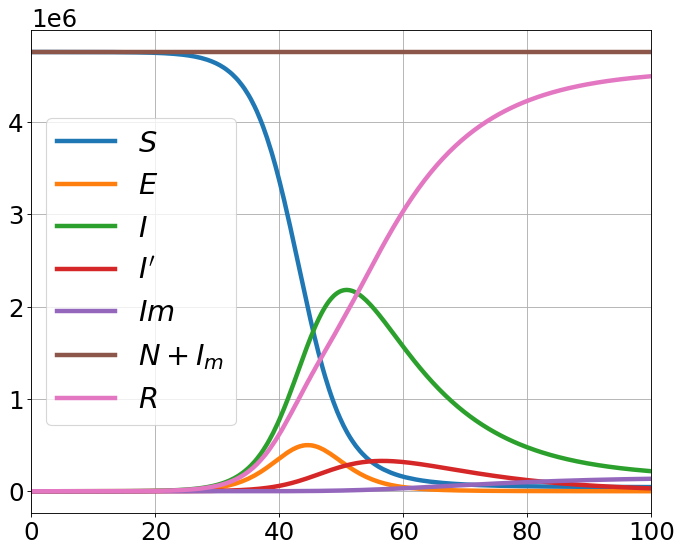

In [6]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

total_w = 0.0
total_r = 0.0
for i in range(Nnode):
    total_w += Nw[M][i]
    total_r += Nh[M][i]
#print('Toatl', total_w, total_r)

S_total = []
E_total = []
I_total = []
Im_total = []
PR_total = []
N_total = []
for i in range(len(Ia[0])):
    S_total.append(0.0)
    E_total.append(0.0)
    I_total.append(0.0)
    Im_total.append(0.0)
    PR_total.append(0.0)
    N_total.append(0.0)
for i in range(M1):
    S_total  += S[i]
    E_total  += E[i]
    I_total  += Ia[i] + Is[i] + Ih[i] + Ic[i] + Im[i]
    PR_total += Isd[i] + Ihd[i] + Icd[i]
    Im_total += Im[i]
    N_total  += N[i] + Im[i]
plt.plot(t/24, S_total, '-', label='$S$', lw=4)
plt.plot(t/24, E_total, '-', label='$E$', lw=4)
plt.plot(t/24, I_total, '-', label='$I$', lw=4)
plt.plot(t/24, PR_total, '-', label='$I\'$', lw=4)
plt.plot(t/24, Im_total, '-', label='$Im$', lw=4)
plt.plot(t/24, N_total, '-', label='$N+I_{m}$', lw=4)
plt.plot(t/24, total_r - S_total - I_total, '-', label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
#plt.autoscale(enable=True, axis='x', tight=True)

ax=plt.subplot()
#ax.grid(which="both")
#ax.set_xlabel("x")
#ax.set_ylabel("y")

ax.set_xlim([0,100])
#ax.set_ylim([0,2.0*10**1])

f_data = open('network-SEI8R.txt', mode='w')
for i in range(len(t)):
    f_data.write(str(t[i]/24) + ' ' + str(S_total[i]) + ' ' + str(I_total[i]) + '\n')
f_data.close()